### Uvozimo neophodne biblioteke

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.impute import SimpleImputer
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from prophet import Prophet
from sklearn.utils.class_weight import compute_class_weight

### Učitavamo podatke i generišemo osnovne grafike

In [156]:
path = "/Users/aleksamilovanovic/Downloads/tabela.xlsx"
df = pd.read_excel(path)
print(df.columns)

Index(['Пол', 'Датум испитивања', 'Датум рођења', 'Старост', 'Висина (cm)',
       'Дужина главе', 'Ширина главе', 'Кефалични индекс', 'Ширина лица',
       'Висина лица', 'Морфолошки индекс лица', 'Висина носа', 'Ширина носа',
       'Назални индекс'],
      dtype='object')


In [157]:
df["Старосна група"] = pd.cut(df["Старост"], bins=[0, 20, 21, 22, 23], labels=["20", "21", "22", "23"])
print(df.describe())

                    Датум испитивања                   Датум рођења  \
count                            381                            381   
mean   2011-05-10 05:55:16.535432960  1989-12-15 12:17:00.472440960   
min              2001-04-28 00:00:00            1977-12-28 00:00:00   
25%              2004-09-22 00:00:00            1982-07-02 00:00:00   
50%              2005-10-03 00:00:00            1984-07-05 00:00:00   
75%              2021-04-15 00:00:00            2000-02-15 00:00:00   
max              2021-04-15 00:00:00            2003-06-01 00:00:00   
std                              NaN                            NaN   

          Старост  Висина (cm)  Дужина главе  Ширина главе  Кефалични индекс  \
count  381.000000   381.000000    381.000000    381.000000        381.000000   
mean    21.396137   170.151706     18.502887     14.344357         77.595645   
min     17.872690   143.300000     15.400000      7.200000         41.860465   
25%     20.651608   164.000000     17.80

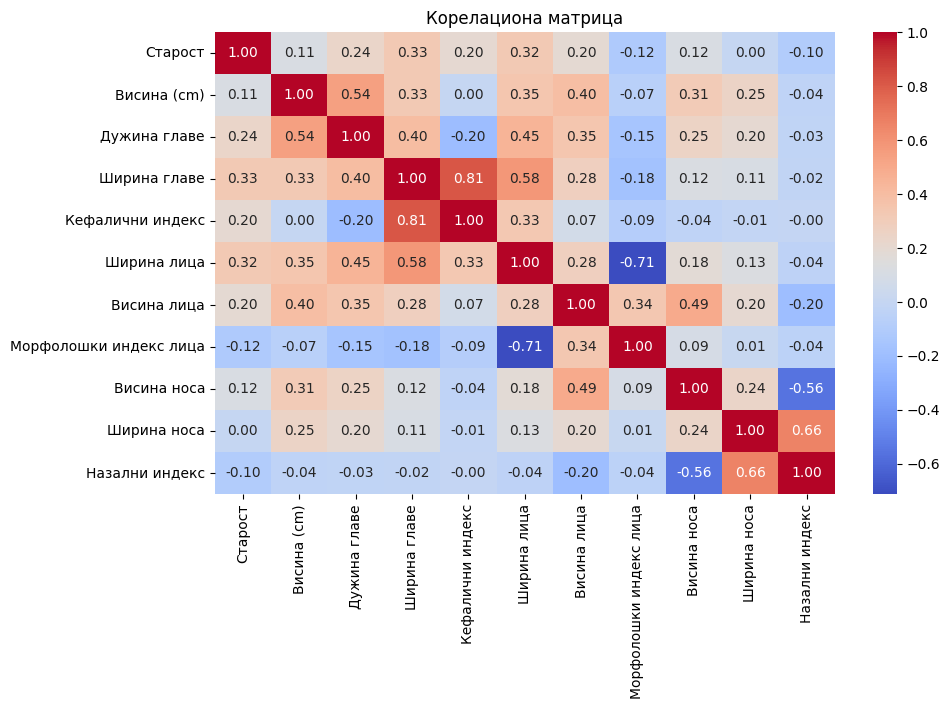

In [161]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корелациона матрица")
plt.show()

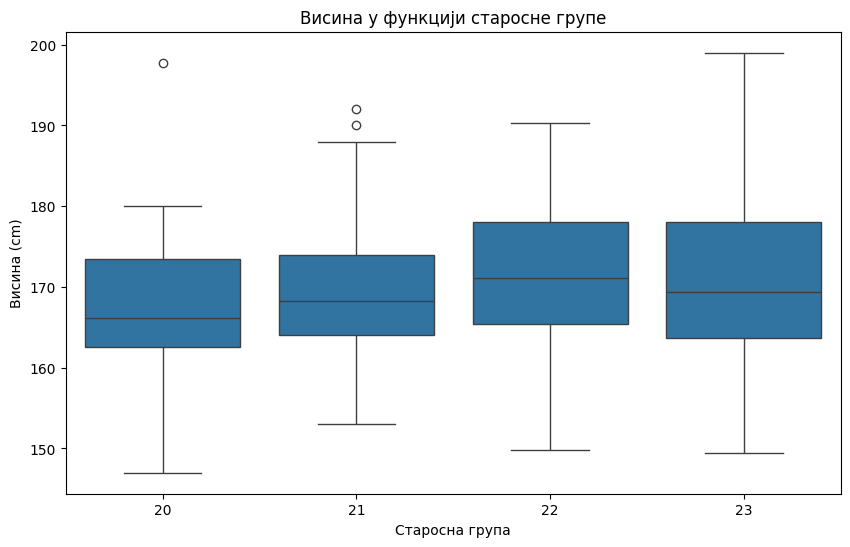

In [159]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Старосна група", y="Висина (cm)", data=df)
plt.title("Висина у функцији старосне групе")
plt.show()

### Statistički testovi

In [109]:
anova_p = stats.f_oneway(df[df["Старосна група"] == "20"]["Висина (cm)"],
                         df[df["Старосна група"] == "21"]["Висина (cm)"],
                         df[df["Старосна група"] == "22"]["Висина (cm)"],
                         df[df["Старосна група"] == "23"]["Висина (cm)"])
print("ANOVA p-vrednost za visinu:", anova_p.pvalue)

ANOVA p-vrednost za visinu: 0.056029628399641596


In [ ]:
tukey = pairwise_tukeyhsd(df['Висина (cm)'], df['Старост'], alpha=0.0561)
print(tukey.summary())

### Klasifikacija i regresija

In [169]:
X = df[["Дужина главе", "Ширина главе", "Ширина лица"]]
y = df["Старосна група"]

df_combined = pd.concat([X, y], axis=1).dropna()

X_train, X_test, y_train, y_test = train_test_split(df_combined.drop(columns=["Старосна група"]), 
                                                    df_combined["Старосна група"], 
                                                    test_size=0.2, 
                                                    random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classes = np.array(y_train.unique())
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

models = {
    "Random Forest": RandomForestClassifier(class_weight=class_weight_dict),
    "SVM": SVC(class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_test_str = y_test.astype(str)
    y_pred_str = y_pred.astype(str)
    
    print(f"{name} Klasifikacija:\n", classification_report(y_test_str, y_pred_str))

Random Forest Klasifikacija:
               precision    recall  f1-score   support

          20       0.36      0.36      0.36        11
          21       0.20      0.16      0.18        19
          22       0.56      0.62      0.59        24
          23       0.47      0.50      0.48        16

    accuracy                           0.43        70
   macro avg       0.40      0.41      0.40        70
weighted avg       0.41      0.43      0.42        70

SVM Klasifikacija:
               precision    recall  f1-score   support

          20       0.32      0.64      0.42        11
          21       0.35      0.32      0.33        19
          22       0.65      0.46      0.54        24
          23       0.57      0.50      0.53        16

    accuracy                           0.46        70
   macro avg       0.47      0.48      0.46        70
weighted avg       0.50      0.46      0.46        70

Logistic Regression Klasifikacija:
               precision    recall  f1-score 

In [170]:
X = df[["Старост"]]
y = df["Висина (cm)"]

ridge = Ridge().fit(X_train, y_train)
lasso = Lasso().fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
print("Ridge MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Lasso MSE:", mean_squared_error(y_test, y_pred_lasso))

Ridge MSE: 0.7775577944990782
Lasso MSE: 1.017130879058316


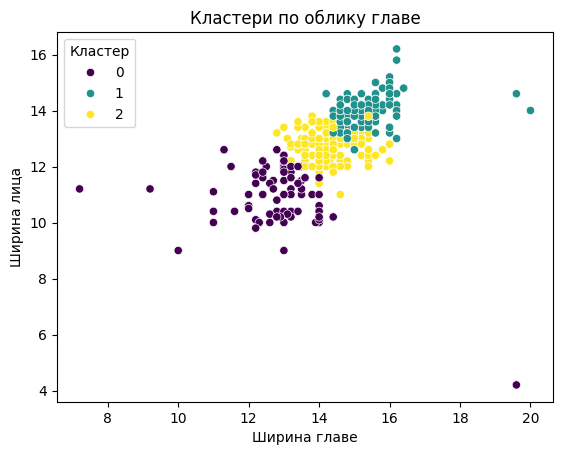

In [171]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[["Дужина главе", "Ширина главе", "Ширина лица"]])
df["Кластер"] = kmeans.labels_
sns.scatterplot(x=df["Ширина главе"], y=df["Ширина лица"], hue=df["Кластер"], palette="viridis")
plt.title("Кластери по облику главе")
plt.show()

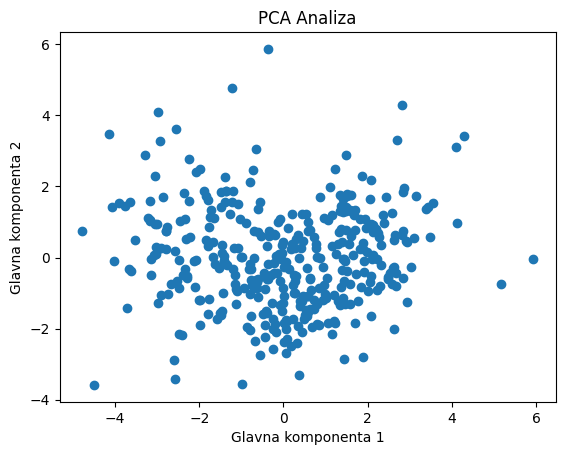

In [ ]:
imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(imputer.fit_transform(df.iloc[:, 3:-1]), columns=df.columns[3:-1])
X_scaled = scaler.fit_transform(df_imputed)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA Анализа")
plt.xlabel("Glavna komponenta 1")
plt.ylabel("Glavna komponenta 2")
plt.show()

### Предвиђања

12:53:09 - cmdstanpy - INFO - Chain [1] start processing
12:53:10 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
12:53:10 - cmdstanpy - INFO - Chain [1] start processing
12:53:10 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
12:53:10 - cmdstanpy - INFO - Chain [1] start processing
12:53:10 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE'

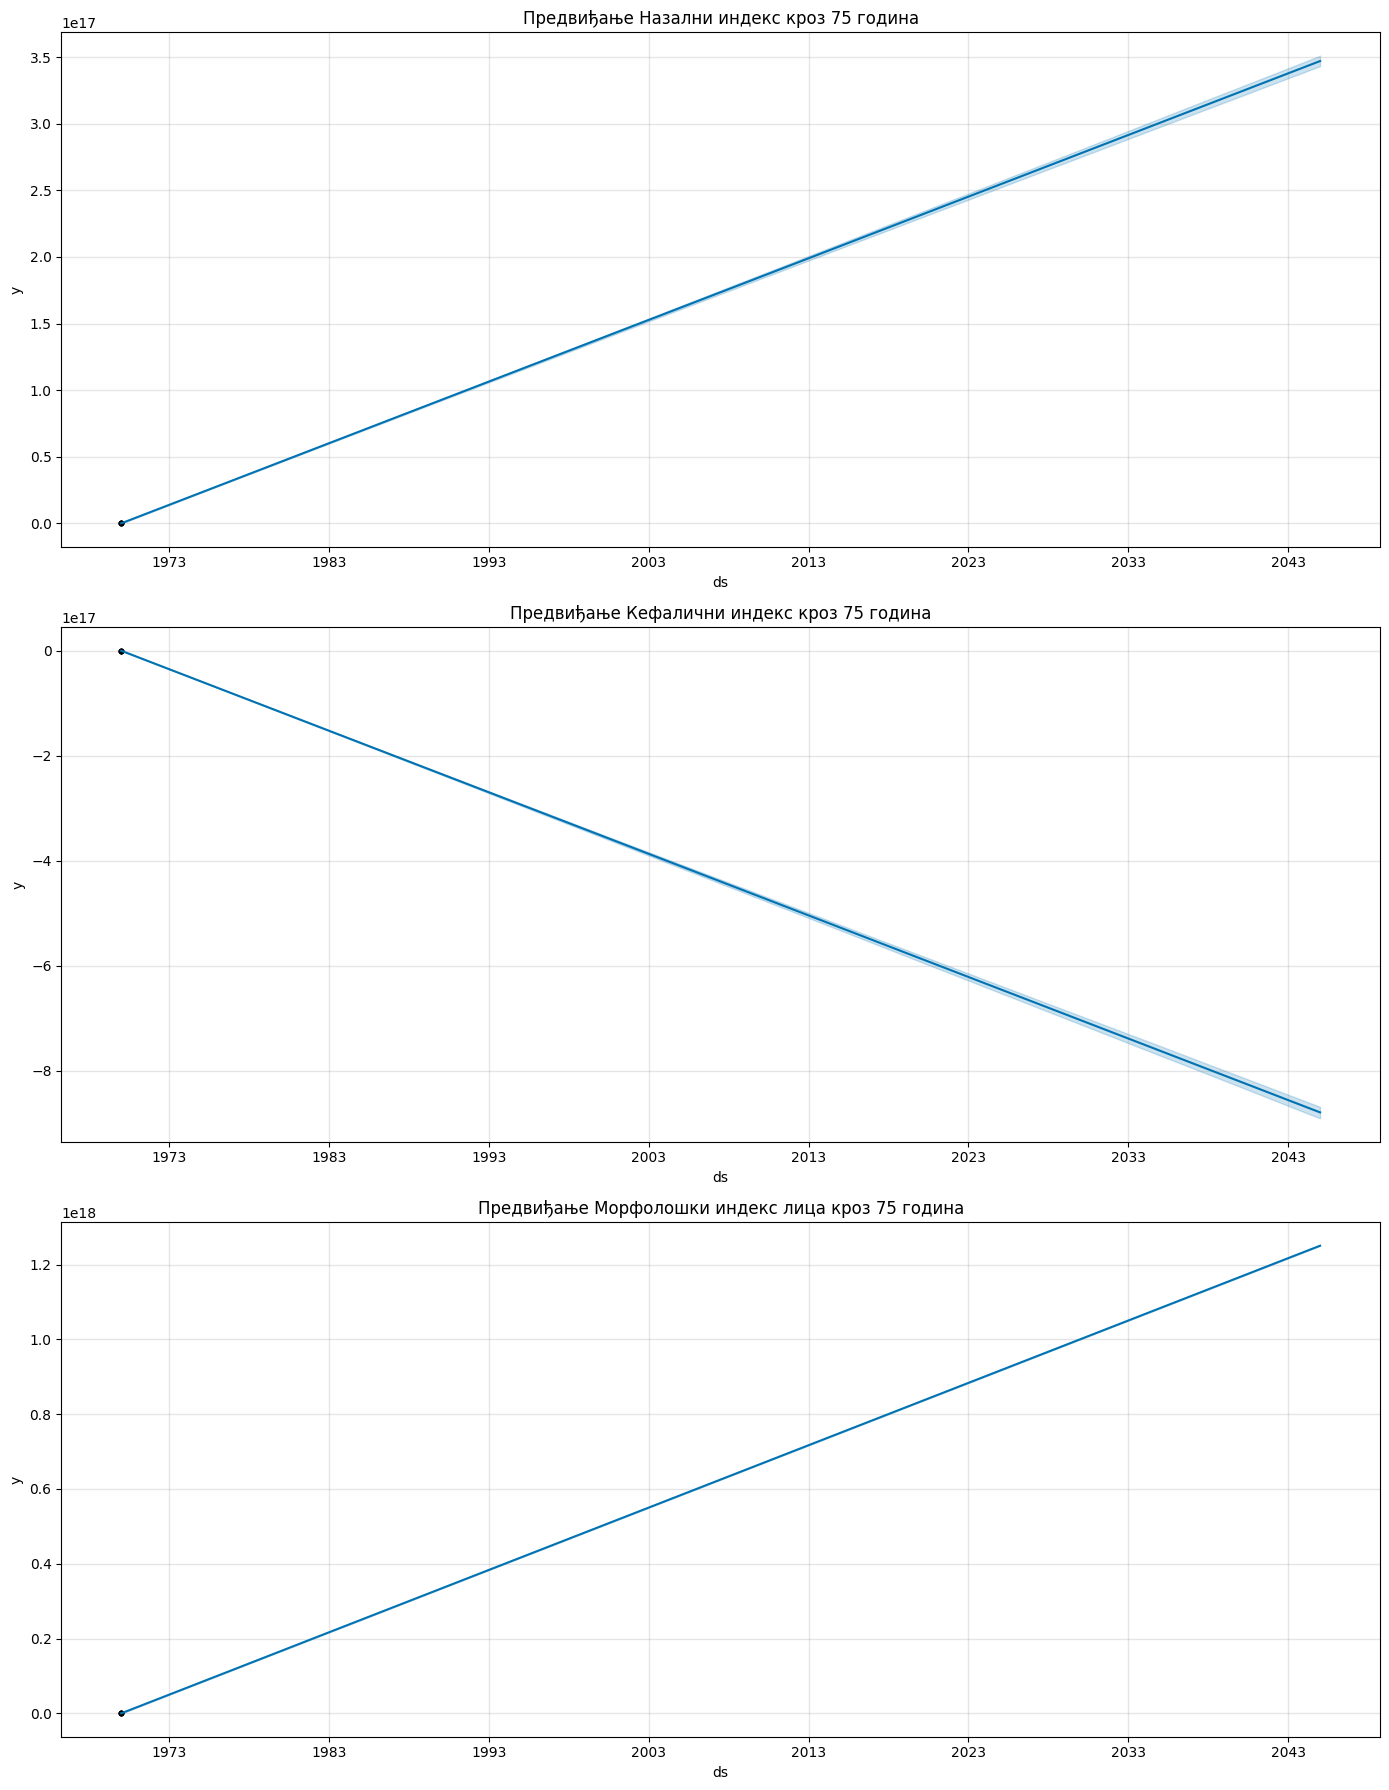

In [179]:
df['Година рођења'] = pd.to_datetime(df['Датум рођења']).dt.year
df['Подаци година'] = pd.to_datetime(df['Датум испитивања']).dt.year
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
indices = ['Назални индекс', 'Кефалични индекс', 'Морфолошки индекс лица']

for i, index in enumerate(indices):
    vremenska_serija = df.groupby('Подаци година')[index].mean().reset_index()
    vremenska_serija.columns = ['ds', 'y']
    
    model = Prophet()
    model.fit(vremenska_serija)
    buducnost = model.make_future_dataframe(periods=75, freq='Y') 
    forecast = model.predict(buducnost)
    ax = axes[i]
    model.plot(forecast, ax=ax)
    ax.set_title(f'Предвиђање {index} кроз 75 година')

plt.tight_layout()
plt.show()